In [51]:
import numpy as np
import pandas as pd
import os
import gc
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from scipy.stats import uniform
from sklearn.utils.fixes import loguniform
import seaborn as sns
import matplotlib.pyplot as plt
rc_params = {
    'legend.fontsize': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16}
plt.rcParams.update(rc_params)



data_path = "data"

# 1. INTRODUCTION


huge amount of data
    

<b> check data </b><br>
$ ls -lh ./data
187M  2019 sample_submission.csv <br>
824M Dec 12  2019 test.csv <br>
2.5G Dec 12  2019 test_supplement.csv <br>
7.1G Dec 12  2019 train.csv <br>
3.9M Dec 12  2019 train_sample.csv <br>

$ cat train.csv | wc -l<br>
184903891

$ cat test.csv | wc -l<br>
18790470



use gc (garbage collector). I woulc be better to  delete constantly unncessary things.<br>
use dask instead of pandas <br>
read csv chunk by chunk or use feather <br>
use appropriate dyteps while reading file columns to reduce memory usage <br>



# 2. EDA

### 2.1 train_sample dataset

glimpse the sample train dataset to see data, fields, etc.

In [5]:
train_sample_df = pd.read_csv(os.path.join(data_path, "train_sample.csv"))
train_sample_df.head()    

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [7]:
train_sample_df['click_time'].min(), train_sample_df['click_time'].max()

('2017-11-06 16:00:00', '2017-11-09 15:59:51')

In [8]:
value_counts = train_sample_df['is_attributed'].value_counts()
value_counts

0    99773
1      227
Name: is_attributed, dtype: int64

In [9]:
round(100 * (value_counts.iloc[1] / len(train_sample_df)),3)

0.227

### 2.2 test dataset

In [10]:
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
test_df.head()   

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   click_id    int64 
 1   ip          int64 
 2   app         int64 
 3   device      int64 
 4   os          int64 
 5   channel     int64 
 6   click_time  object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB


In [12]:
test_df['click_time'].min(), test_df['click_time'].max()

('2017-11-10 04:00:00', '2017-11-10 15:00:00')

### 2.3 Descriptive stats

In [13]:
train_sample_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [14]:
test_df.describe()

,click_id,ip,app,device,os,channel
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02


<b> Comment </b><br> 
1. attributed_time empty and not in test: remove unused column 

2. pandas assign int64 to all integers,  correct dtype can be specified while loading data to reduce memory usage <br>.
int8 can store integers from -128 to 127.
int16 can store integers from -32768 to 32767.<br>
    
    * is_attributed is either 0 or 1, so it can bes cast to uint8<br>
    * channel changes between (0,498), so it can bes cast to uint16<br>
    
3. testset includes data from only at 2017-11-10. Morever, minutes&seconds could be removed from click_time, even tough they might give an idea about fraud movements. Hoever, .... A very large number of clicks from the same IP in a very short time can be used for fraud detection. <br>

4. it is not posibbile to read all train data due to hardrwade limitation. I need to sample it (~4M). On the other hand, fraudelent attributes are %0.22 of sampled train data. it seems highly unbalanced. Therefore it is better to read all fraud attirbuted value.

### 2.3 train dataset (all positive attributes and sampled negative attributes)

In [15]:
dtypes = {
    'ip'            : 'uint32', # changes between [0,364757] in sampled train dataset and test dataset
    'app'           : 'uint16', # changes between [0,511] in sampled train dataset and test dataset
    'device'        : 'uint16', # changes between [0,3867] in sampled train dataset and test dataset
    'os'            : 'uint16', # changes between [0,866] in sampled train dataset and test dataset
    'channel'       : 'uint16', # changes between [0,498] in sampled train dataset and test dataset
    'is_attributed' : 'uint8'   # binary variable
}
usecols = ['ip', 'app', 'device', 'os', 'channel','is_attributed', 'click_time']

chunksize = 4*(10**6)
neg_sample_size = chunksize // (180*(10**6)// chunksize)


train_df_list = []
for chunked_df in  pd.read_csv(os.path.join(data_path, "train.csv"), dtype=dtypes, usecols=usecols, chunksize=chunksize):
    train_df_list.append(chunked_df[chunked_df['is_attributed']==1])
    train_df_list.append(chunked_df[chunked_df['is_attributed']==0].sample(n=neg_sample_size))
    
    print(chunked_df['is_attributed'].value_counts())
    print("-"*12)
    
    del chunked_df
    gc.collect()

train_df = pd.concat(train_df_list)
train_df.describe()

0    3993058
1       6942
Name: is_attributed, dtype: int64
------------
0    3991802
1       8198
Name: is_attributed, dtype: int64
------------
0    3991750
1       8250
Name: is_attributed, dtype: int64
------------
0    3988062
1      11938
Name: is_attributed, dtype: int64
------------
0    3985864
1      14136
Name: is_attributed, dtype: int64
------------
0    3989093
1      10907
Name: is_attributed, dtype: int64
------------
0    3990748
1       9252
Name: is_attributed, dtype: int64
------------
0    3989739
1      10261
Name: is_attributed, dtype: int64
------------
0    3989236
1      10764
Name: is_attributed, dtype: int64
------------
0    3987414
1      12586
Name: is_attributed, dtype: int64
------------
0    3989836
1      10164
Name: is_attributed, dtype: int64
------------
0    3988283
1      11717
Name: is_attributed, dtype: int64
------------
0    3988109
1      11891
Name: is_attributed, dtype: int64
------------
0    3990202
1       9798
Name: is_attributed, dtyp

,ip,app,device,os,channel,is_attributed
count,4.634582e+06,4.634582e+06,4.634582e+06,4.634582e+06,4.634582e+06,4.634582e+06
mean,9.821082e+04,1.372415e+01,2.256507e+01,2.283386e+01,2.622898e+02,9.857329e-02
std,7.718802e+04,1.823492e+01,2.550767e+02,5.520052e+01,1.296426e+02,2.980883e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.201900e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,8.294100e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.450000e+02,0.000000e+00
75%,1.239200e+05,1.800000e+01,1.000000e+00,1.900000e+01,3.770000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.223000e+03,9.020000e+02,4.980000e+02,1.000000e+00


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634582 entries, 103 to 184556942
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ip             uint32
 1   app            uint16
 2   device         uint16
 3   os             uint16
 4   channel        uint16
 5   click_time     object
 6   is_attributed  uint8 
dtypes: object(1), uint16(4), uint32(1), uint8(1)
memory usage: 128.2+ MB


In [17]:
value_count = train_df['is_attributed'].value_counts()
fraud_attributes =  100 * (value_count.iloc[1]) / 184903891
print("fraud %.2f %%\nnormal %.2f %%" % (fraud_attributes, 100-fraud_attributes))

fraud 0.25 %
normal 99.75 %


<b>Comment:</b> <br>
    1. even in whole train dataset fraud ratio is highly less %0.25 very close to sampled train dataset<br>
    2. value range is also very similar, dtpes settings ok


### 2.4 analysis of target variable

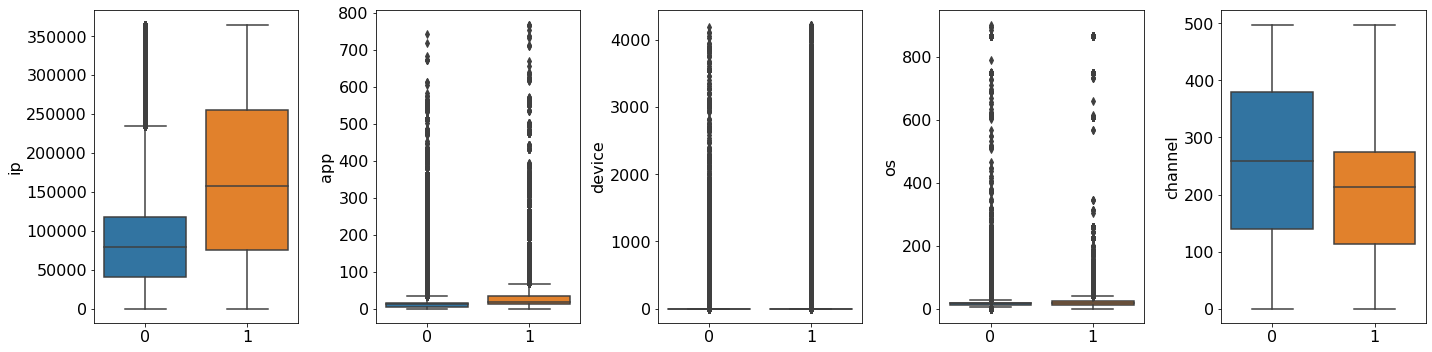

In [18]:
cols = ['ip', 'app', 'device', 'os', 'channel']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(20, 5))
for ix, col_name in enumerate(cols): 
    ax = axes[ix] 
    sns.boxplot(x='is_attributed', y=col_name, data=train_df, ax=ax)
    ax.set_ylabel(col_name) 
    ax.set_xlabel('') 
fig.tight_layout()

/home/vitus/anaconda3/envs/take_home/lib/python3.7/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/vitus/anaconda3/envs/take_home/lib/python3.7/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/vitus/anaconda3/envs/take_home/lib/python3.7/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/vitus/anaconda3/envs/take_home/lib/python3.7/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/vitus/

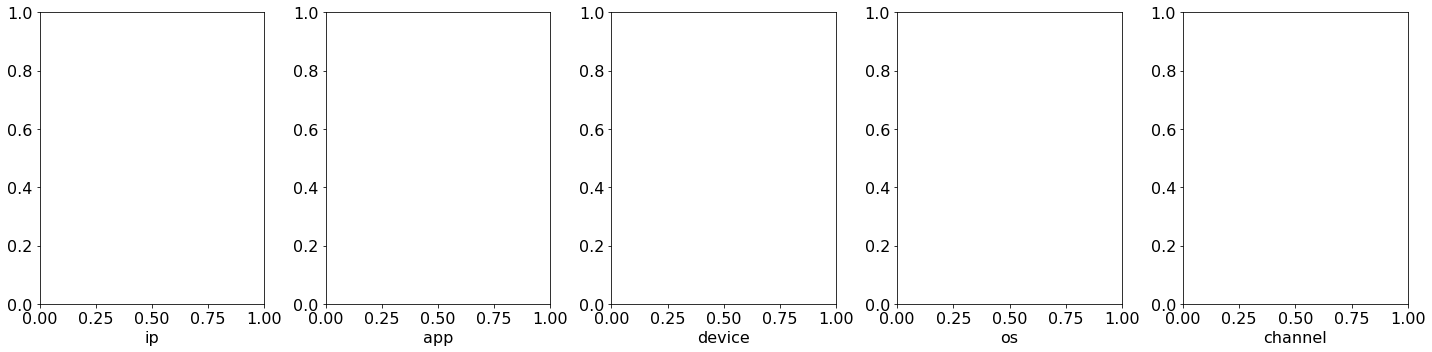

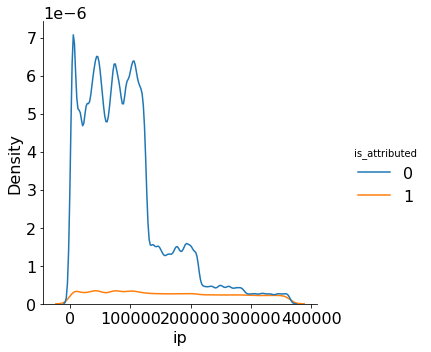

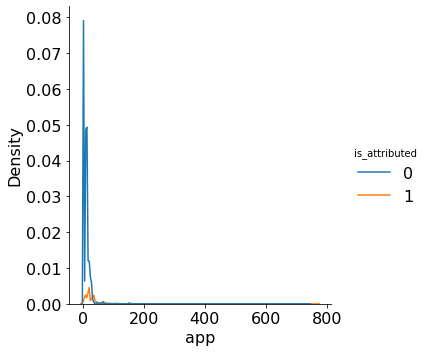

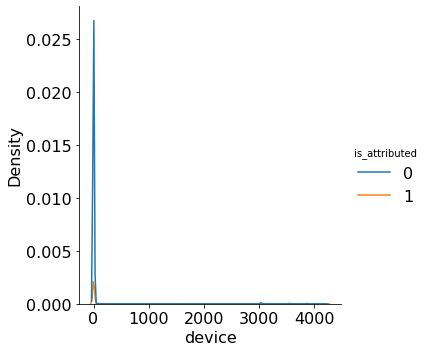

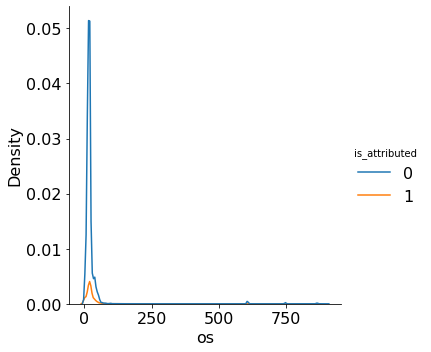

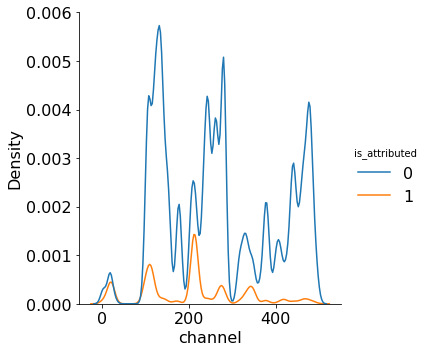

In [19]:
cols = ['ip', 'app', 'device', 'os', 'channel']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(20, 5))
for ix, col_name in enumerate(cols): 
    ax = axes[ix] 
    sns.displot(data=train_df, x=col_name, hue='is_attributed', ax=ax, kind="kde")
    ax.set_ylabel('') 
    ax.set_xlabel(col_name) 
fig.tight_layout()

<b>Comment:</b> ip, os, channel distburibution differs for both class. But app and device is almost identical 

# 3. Feature Engineering

### 3.1 datetime features

In [20]:
for fea in ['minute', 'hour', 'dayofweek']:
    train_df[fea] =  pd.to_datetime(train_df['click_time']).dt.__getattribute__(fea).astype('uint8')
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed,minute,hour,dayofweek
103,204158,35,1,13,21,2017-11-06 15:41:07,1,41,15,0
1504,29692,9,1,22,215,2017-11-06 16:00:02,1,0,16,0
1798,64516,35,1,13,21,2017-11-06 16:00:02,1,0,16,0
2102,172429,35,1,46,274,2017-11-06 16:00:03,1,0,16,0
3056,199085,35,1,13,274,2017-11-06 16:00:04,1,0,16,0


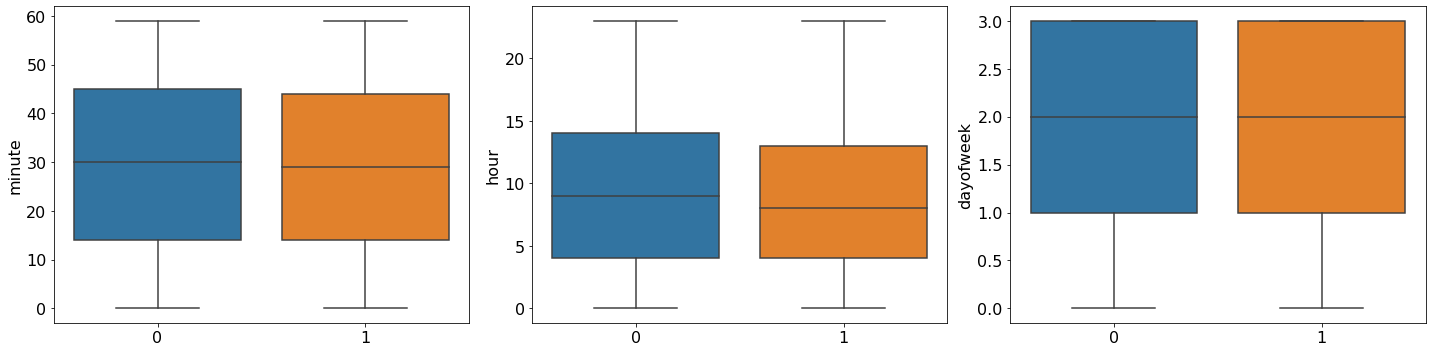

In [21]:
cols = ['minute', 'hour', 'dayofweek']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(20, 5))
for ix, col_name in enumerate(cols): 
    ax = axes[ix] 
    sns.boxplot(x='is_attributed', y=col_name, data=train_df, ax=ax)
    ax.set_ylabel(col_name) 
    ax.set_xlabel('') 
fig.tight_layout()

In [22]:
train_df['click_time'].min(), train_df['click_time'].max()

('2017-11-06 14:57:50', '2017-11-09 16:00:00')

<b>Comment:</b> there are only four days data, keep day instead of click_time

### 3.2 aggregation features

In [23]:
def aggregate(df, columns, on, operation, dtype='', debug=True):
    """
    this method provide as generic functionality of aggregation operations
    """
    
    # aggregate
    col_name = "{operation}_{columns}_on_{on}".format(operation=operation, columns='_'.join(columns), on='_'.join(on))
    agg_df = df.groupby(on)[columns].agg(operation)
    agg_df.columns = [col_name]
    
    # cast if dtype exists
    if dtype:
        agg_df[col_name] = agg_df[col_name].astype(dtype)
    
    # merge with main dataframe
    df = pd.merge(df, agg_df.reset_index(), left_on=on, right_on=on, how='left')
    
    # show class distribution in debug mode
    if debug:
        print("%s - %s" % (agg_df.min(), agg_df.max()))
        print("mean(class 0):%.1f\nmean(class 1):%.1f" % (
            df.loc[df['is_attributed']==0, col_name].mean(),
            df.loc[df['is_attributed']==1, col_name].mean()))
          
    del agg_df
    gc.collect()
    
    if not debug:
        return df

In [24]:
aggregate(train_df, ['channel'], ['ip', 'os'], 'count')

count_channel_on_ip_os    1
dtype: int64 - count_channel_on_ip_os    6478
dtype: int64
mean(class 0):120.9
mean(class 1):54.6


In [25]:
aggregate(train_df, ['channel'], ['ip', 'device'], 'count')

count_channel_on_ip_device    1
dtype: int64 - count_channel_on_ip_device    25869
dtype: int64
mean(class 0):843.4
mean(class 1):322.8


In [26]:
aggregate(train_df, ['channel'], ['ip', 'app'], 'count')

count_channel_on_ip_app    1
dtype: int64 - count_channel_on_ip_app    4770
dtype: int64
mean(class 0):111.4
mean(class 1):20.0


In [27]:
aggregate(train_df, ['channel'], ['ip', 'os', 'app'], 'count')

count_channel_on_ip_os_app    1
dtype: int64 - count_channel_on_ip_os_app    1196
dtype: int64
mean(class 0):14.0
mean(class 1):4.2


In [28]:
aggregate(train_df, ['channel'], ['ip', 'hour', 'dayofweek'], 'count')

count_channel_on_ip_hour_dayofweek    1
dtype: int64 - count_channel_on_ip_hour_dayofweek    1388
dtype: int64
mean(class 0):24.1
mean(class 1):13.5


In [29]:
aggregate(train_df, ['hour'], ['ip', 'app'], 'mean')

mean_hour_on_ip_app    0.0
dtype: float64 - mean_hour_on_ip_app    23.0
dtype: float64
mean(class 0):9.4
mean(class 1):8.7


In [30]:
aggregate(train_df, ['hour'], ['ip', 'app'], 'std')

std_hour_on_ip_app    0.0
dtype: float64 - std_hour_on_ip_app    16.263456
dtype: float64
mean(class 0):5.7
mean(class 1):4.4


In [31]:
aggregate(train_df, ['hour'], ['ip', 'app', 'channel'], 'mean')

mean_hour_on_ip_app_channel    0.0
dtype: float64 - mean_hour_on_ip_app_channel    23.0
dtype: float64
mean(class 0):9.4
mean(class 1):8.7


In [32]:
aggregate(train_df, ['hour'], ['ip', 'app', 'channel'], 'std')

std_hour_on_ip_app_channel    0.0
dtype: float64 - std_hour_on_ip_app_channel    16.263456
dtype: float64
mean(class 0):5.2
mean(class 1):4.0


<b>Comment:</b> aggregation features, especially ones counts on channel column, seem disciriminative

# 4. Model Development

### 4.1 prepare datasets for modelling

In [33]:
train_df.drop(['click_time', 'minute', 'device'], axis=1, inplace=True)
train_df.columns

Index(['ip', 'app', 'os', 'channel', 'is_attributed', 'hour', 'dayofweek'], dtype='object')

In [34]:
for fea in ['hour', 'dayofweek']:
    test_df[fea] =  pd.to_datetime(test_df['click_time']).dt.__getattribute__(fea).astype('uint8')
test_df.drop(['click_id', 'click_time', 'device'], axis=1,inplace=True)
test_df.columns

Index(['ip', 'app', 'os', 'channel', 'hour', 'dayofweek'], dtype='object')

In [35]:
train_len = len(train_df)
train_y = train_df['is_attributed']
all_df=train_df.drop(['is_attributed'], axis=1).append(test_df)

del train_df
del test_df
gc.collect()

88

In [36]:
def feature_enrichment(df):
    """
    perform aggregation feature enrichment for a given dataframe
    """
    
    df = aggregate(df, ['channel'], ['ip', 'app'], 'count', dtype='uint16', debug=False)
    df = aggregate(df, ['channel'], ['ip', 'app', 'os'], 'count', dtype='uint16', debug=False)
    df = aggregate(df, ['channel'], ['ip', 'hour', 'dayofweek'], 'count', dtype='uint16', debug=False)
    df = aggregate(df, ['hour'], ['ip', 'app', 'channel'], 'mean', dtype='uint8', debug=False)
    df = aggregate(df, ['hour'], ['ip', 'app', 'os'], 'mean', dtype='uint8', debug=False)
    # .... TODO: etc.
    
    gc.collect()
    return df

In [37]:
all_df = feature_enrichment(all_df)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23425051 entries, 0 to 23425050
Data columns (total 11 columns):
 #   Column                              Dtype 
---  ------                              ----- 
 0   ip                                  int64 
 1   app                                 int64 
 2   os                                  int64 
 3   channel                             int64 
 4   hour                                uint8 
 5   dayofweek                           uint8 
 6   count_channel_on_ip_app             uint16
 7   count_channel_on_ip_app_os          uint16
 8   count_channel_on_ip_hour_dayofweek  uint16
 9   mean_hour_on_ip_app_channel         uint8 
 10  mean_hour_on_ip_app_os              uint8 
dtypes: int64(4), uint16(3), uint8(4)
memory usage: 1.1 GB


In [42]:
# divide datasettrain, validation, test
val_len = int(train_len*0.3)

train_X = all_df[:(train_len-val_len)]
val_X = all_df[(train_len-val_len):train_len]
test_X = all_df[train_len:]

y_val = train_y[(train_len-val_len):]
y_train = train_y[:(train_len-val_len)]

### 4.2 simplest models

In [44]:
def run_model(clf):
    """
    train a defined model on train dataset and perform prediction on validation set.
    """
    
    clf.fit(train_X, y_train)
    y_val_pred=clf.predict(val_X)
    print(roc_auc_score(y_val, y_val_pred))
    del clf
    del y_val_pred
    gc.collect()

In [47]:
# lgbm classifier
clf_lgb = lgb.LGBMClassifier()
run_model(clf_lgb)

0.8992334407123728


In [48]:
# lgbm classifier considering unbalanced classes
clf_lgb = lgb.LGBMClassifier(is_unbalance = True) #scale_pos_weight=99)
run_model(clf_lgb)

0.9181189274071911


In [49]:
# ensemble with RandomClassifier

# note: since the training time of the model takes long, this part commented
#
# clf_rf = RandomForestClassifier(class_weight='balanced')
# run_model(clf_rf)

# clf_ens = VotingClassifier(estimators=[('lgb', clf_lgb), ('rf', clf_rf))
# run_model(clf_ens)      

### 4.3 select best model

In [58]:
hyper_params = {
    'n_estimators'  : np.arange(200, 1000, 20),
    'max_depth'     : np.arange(2, 8, 1),
    'learning_rate' : uniform(0.01, 0.19),
    'subsample'     : loguniform(0.8, 1)
}

cv = model_selection.StratifiedKFold(n_splits=2)
search = model_selection.RandomizedSearchCV(
    estimator= lgb.LGBMClassifier(is_unbalance=True), 
    param_distributions=hyper_params, 
    scoring='roc_auc',
    cv=cv, 
    n_iter=5, 
    random_state=10)

In [ ]:
search.fit(train_X, y_train)
y_val_pred=search.predict(val_X)
print(roc_auc_score(y_val, y_val_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [57]:
best_model = search.best_estimator_
print('Best cv score:    {}'.format(search.best_score_))
print('Best parameters:  {}'.format(search.best_params_))
print('Best model:       {}'.format(best_model))

Best cv score:    0.964045304045136
Best parameters:  {'learning_rate': 0.04764314447626435, 'max_depth': 3, 'n_estimators': 360, 'num_leaves': 32, 'subsample': 0.8538384353032953}
Best model:       LGBMClassifier(is_unbalance=True, learning_rate=0.04764314447626435,
               max_depth=3, n_estimators=360, num_leaves=32,
               subsample=0.8538384353032953)
